# 回帰分析を実行するプログラム

In [1]:
import sys
sys.path.append('..')
from Constants import Constants

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import re

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import seaborn
import pyperclip
import os

import scipy.stats

/Users/miyakooti/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
pd.set_option('display.max_columns', 50)

In [4]:
mkdir_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}"

os.system("mkdir " + mkdir_path)
os.system("mkdir " + mkdir_path + "/image")
os.system("mkdir " + mkdir_path + "/regression")
os.system("mkdir " + mkdir_path + "/regression/by_phase")

mkdir: /Users/miyakooti/repositories/arai_MATLAB_program/csv/analysis_results/20240627_kyoto: File exists
mkdir: /Users/miyakooti/repositories/arai_MATLAB_program/csv/analysis_results/20240627_kyoto/image: File exists
mkdir: /Users/miyakooti/repositories/arai_MATLAB_program/csv/analysis_results/20240627_kyoto/regression: File exists
mkdir: /Users/miyakooti/repositories/arai_MATLAB_program/csv/analysis_results/20240627_kyoto/regression/by_phase: File exists


256

### ここだけ手動で設定。変更がないか毎度確認すること

In [5]:
pvalue_index = -1

### 分析対象のファイルのパスを正規表現で取得

In [6]:
pathes = glob.glob(f"{Constants.path_to_matlab_repository_folder}/csv/*_*/HRV_and_PLI.csv")
pathes.sort()
pathes

['/Users/miyakooti/repositories/arai_MATLAB_program/csv/0_kumakura/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/10_tenshin/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/11_masanori/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/12_enoki/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/13_ito/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/14_yoshioka/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/15_chizuru/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/1_kim/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/2_souma/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/3_fujii/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/4_tubota/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/5_toki/HRV_and_PLI.csv',
 

In [7]:
len(pathes)

16

# StatsModelsを利用した分析

- [公式ドキュメント](https://www.statsmodels.org/stable/index.html#citation)
- [github](https://github.com/statsmodels/statsmodels)

Seabold, Skipper, and Josef Perktold. “statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 2010.

In [8]:
import statsmodels.api as sm

### フェーズごとの分析

In [9]:
for i,target_phase in enumerate(Constants.target_phases):
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0:
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
    
    export_data = {    
        "target": Constants.target_columns,
        "linear-p": [],
        "linear-rsquared": [],
        "linear-rsquared_adj": [],
        "linear-coef": [],
        "nonlinear-p": [],
        "nonlinear-rsquared": [],
        "nonlinear-rsquared_adj": [],
        "nonlinear-coef": [],
    }

    for target_column in Constants.target_columns:
        
        x = flow_dataset[target_column]
        y = flow_dataset[["questionnaire_average"]]
        
        for k in ["linear", "nonlinear"]:
            if k=="linear":
                # 線形単回帰
                X = sm.add_constant(x)
                model = sm.OLS(y, X)
                results = model.fit()

                export_data["linear-p"].append(results.pvalues[target_column])
                export_data["linear-rsquared"].append(results.rsquared)
                export_data["linear-rsquared_adj"].append(results.rsquared_adj)
                export_data["linear-coef"].append(results.params[target_column])
            if k=="nonlinear":
                # ２次単回帰
                x = x[:,np.newaxis]
                polynomial_features= PolynomialFeatures(degree=2)
                xp = polynomial_features.fit_transform(x)
                xp.shape

                model = sm.OLS(y, xp)
                
                results = model.fit()
                
                export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
                export_data["nonlinear-rsquared"].append(results.rsquared)
                export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
                export_data["nonlinear-coef"].append(results.params[pvalue_index])
                    
 
    
    print(f"\nsaving {target_phase} phase regression results...\n")
    df = pd.DataFrame(export_data)   
    print(df)
    save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/by_phase/{i}_{target_phase}_regression.csv"
    df.to_csv(save_path)  

/Users/miyakooti/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/Users/miyakooti/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/miyakooti/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Suppor


saving rest phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm       NaN              NaN                  NaN   
1                  ibi       NaN              NaN                  NaN   
2                   lf       NaN              NaN                  NaN   
3                   hf       NaN              NaN                  NaN   
4                lf/hf       NaN              NaN                  NaN   
5            kubios_lf       NaN              NaN                  NaN   
6            kubios_hf       NaN              NaN                  NaN   
7         kubios_lf/hf       NaN              NaN                  NaN   
8                 sdsd       NaN              NaN                  NaN   
9                rmssd       NaN              NaN                  NaN   
10               pnn20       NaN              NaN                  NaN   
11               pnn50       NaN              NaN                  NaN

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e


saving boredom phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm  0.282248         0.082007             0.016437   
1                  ibi  0.521993         0.029888            -0.039406   
2                   lf  0.747151         0.007664            -0.063217   
3                   hf  0.539332         0.027503            -0.041961   
4                lf/hf  0.665912         0.013704            -0.056746   
5            kubios_lf  0.882108         0.001627            -0.069686   
6            kubios_hf  0.647802         0.015328            -0.055006   
7         kubios_lf/hf  0.824085         0.003651            -0.067517   
8                 sdsd  0.480796         0.036121            -0.032727   
9                rmssd  0.209762         0.109883             0.046303   
10               pnn20  0.397447         0.051615            -0.016127   
11               pnn50  0.458120         0.039925            -0.028

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e


saving flow phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm  0.239369         0.097367             0.032893   
1                  ibi  0.678891         0.012605            -0.057923   
2                   lf  0.298582         0.076850             0.010911   
3                   hf  0.326803         0.068687             0.002164   
4                lf/hf  0.680968         0.012434            -0.058106   
5            kubios_lf  0.133031         0.153774             0.093329   
6            kubios_hf  0.293871         0.078303             0.012467   
7         kubios_lf/hf  0.483046         0.035759            -0.033115   
8                 sdsd  0.099873         0.181515             0.123052   
9                rmssd  0.028336         0.299162             0.249102   
10               pnn20  0.055993         0.236719             0.182199   
11               pnn50  0.024135         0.313377             0.264332


saving overload phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm  0.785002     5.493847e-03            -0.065542   
1                  ibi  0.918319     7.781852e-04            -0.070595   
2                   lf  0.398587     5.137280e-02            -0.016386   
3                   hf  0.201342     1.137950e-01             0.050495   
4                lf/hf  0.483161     3.574037e-02            -0.033135   
5            kubios_lf  0.047158     2.527637e-01             0.199390   
6            kubios_hf  0.290361     7.940319e-02             0.013646   
7         kubios_lf/hf  0.954000     2.462795e-04            -0.071165   
8                 sdsd  0.144135     1.460081e-01             0.085009   
9                rmssd  0.470682     3.778308e-02            -0.030947   
10               pnn20  0.260593     8.940532e-02             0.024363   
11               pnn50  0.285774     8.086490e-02             0.01

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e

# 被験者ごとの分析

In [10]:
# def findSubjectName(path):
#     for subject_name in Constants.subject_name_list:
#         if subject_name in path:
#             return subject_name

In [11]:
# for i,path in enumerate(pathes):

#     df = pd.read_csv(path,index_col=0).fillna(0)
    
#     # ここだけ設定してください。ごめんね
#     flow_dataset = df.iloc[2:6]
#     df = df[["bpm", "ibi", "lf", "hf","lf/hf","FC3","FC4","FCz","mean_3ch","concentration_FC3","concentration_FC4","concentration_FCz","questionnaire_average"]]
    
#     export_data = {
#         "target": Constants.target_columns,
#         "linear-p": [],
#         "linear-rsquared": [],
#         "linear-rsquared_adj": [],
#         "linear-coef": [],
#         "nonlinear-p": [],
#         "nonlinear-rsquared": [],
#         "nonlinear-rsquared_adj": [],
#         "nonlinear-coef": [],
#     }
    
#     for target_column in Constants.target_columns:

#             x = flow_dataset[target_column]
#             y = flow_dataset[["questionnaire_average"]]

#             for k in ["linear", "nonlinear"]:
#                 if k=="linear":
#                     # 線形単回帰
#                     X = sm.add_constant(x)
#                     model = sm.OLS(y, X)
#                     results = model.fit()

#                     export_data["linear-p"].append(results.pvalues[target_column])
#                     export_data["linear-rsquared"].append(results.rsquared)
#                     export_data["linear-rsquared_adj"].append(results.rsquared_adj)
#                     export_data["linear-coef"].append(results.params[target_column])
#                 if k=="nonlinear":
#                     # ２次単回帰
#                     x = x[:,np.newaxis]
#                     polynomial_features= PolynomialFeatures(degree=2)
#                     xp = polynomial_features.fit_transform(x)
#                     xp.shape

#                     model = sm.OLS(y, xp)

#                     results = model.fit()

#                     export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
#                     export_data["nonlinear-rsquared"].append(results.rsquared)
#                     export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
#                     export_data["nonlinear-coef"].append(results.params[pvalue_index])
                    
#     print(f"\nsaving {findSubjectName(path)} regression results...\n")    
#     df = pd.DataFrame(export_data)   
#     print(df)

#     save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/subject/{i}_{findSubjectName(path)}_regression.csv"
#     df.to_csv(save_path)  

https://atmarkit.itmedia.co.jp/ait/articles/2109/14/news024.html

# すべてのフェーズ，すべての被験者のデータをまとめて分析

In [12]:
# 使用するデータセットは一つなので，ここでまとめて作っちゃいましょう

for i,target_phase in enumerate(Constants.target_phases):
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0 and i == 0:
            print("flow_dataset初期化")
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
        
flow_dataset

flow_dataset初期化


,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,lf_diff,hf_diff,lfhf_diff,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
rest,74.087015,809.858521,41.250305,20.146486,36.787621,0.619355,0.183871,30.0,26.012686,52.268898,4271.480335,0.497670,0.300000,396.011131,338.306267,533.157937,0.634533,1267.475336,31.244090,26.691349,42.064561,38.820443,61.179557,0.000000,0.000000,0.000000,257.0,510.0,0.500,0.470375,0.718243,0.530592,0.783054,0.352428,0.286579,0.390179,0.504493,0.677296,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.00
rest,84.110828,713.344538,35.699439,17.214344,27.709366,0.432584,0.067416,22.0,19.593268,46.540635,2864.765352,0.420993,0.133333,267.138630,631.637193,212.740305,2.969053,1111.516129,24.033716,56.826633,19.139651,74.805072,25.194928,0.000000,0.000000,0.000000,591.0,219.0,2.700,0.422667,0.593262,0.690615,0.725889,0.310892,0.438972,0.430201,0.516071,0.669922,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,75.220071,797.659443,40.900640,13.923616,22.012701,0.304348,0.021739,20.0,15.564184,55.685590,2722.820846,0.279501,0.133333,316.777455,1231.720452,138.655648,8.883305,1687.153555,18.775852,73.005830,8.218318,89.881927,10.118073,0.000000,0.000000,0.000000,1044.0,133.0,7.863,0.367564,0.525578,0.305216,0.487435,0.320239,0.311307,0.395218,0.387508,0.439410,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,69.352315,865.147766,97.031908,17.478813,31.990300,0.593103,0.103448,68.0,22.620469,135.393695,9621.658211,0.167072,0.100000,6128.267686,3421.219463,63.168555,54.160166,9612.655704,63.752077,35.590783,0.657139,98.187098,1.812902,0.000000,0.000000,0.000000,3530.0,90.0,39.337,0.413260,0.519220,0.549392,0.696971,0.218319,0.247750,0.270101,0.416431,0.588528,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,75.038981,799.584416,82.250228,34.261413,49.297373,0.567657,0.231023,47.0,34.849896,109.839201,12025.654369,0.317281,0.133333,4390.708426,2147.469055,1332.822690,1.611219,7871.000171,55.783361,27.283306,16.933333,61.703708,38.296292,0.000000,0.000000,0.000000,2373.0,2504.0,0.948,0.254564,0.437716,0.493796,0.484021,0.533929,0.538550,0.234585,0.425309,0.471844,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
overload,67.646856,886.959184,29.955835,14.390555,26.989317,0.511945,0.030717,19.0,19.084313,37.894766,2271.985957,0.503613,0.133333,344.861204,128.672143,182.674378,0.704380,656.207725,52.553664,19.608447,27.837889,41.327631,58.672369,360.961401,268.838068,0.380050,149.0,191.0,0.777,0.142077,0.179835,0.204738,0.273960,0.126628,0.120716,0.227956,0.203727,0.219511,0.278569,0.065311,0.379934,0.241271,1,5.0,3.0,6.0,3.75
overload,70.102050,855.895082,48.317686,23.119517,42.546724,0.690789,0.240132,28.0,30.084852,61.443674,5807.308933,0.489633,0.100000,1638.321753,879.841437,283.156567,3.107261,2801.319758,58.483925,31.408105,10.107970,75.652876,24.347124,-611.399493,819.093326,-2.863721,332.0,335.0,0.991,0.299530,0.209866,0.267556,0.467623,0.137759,0.108795,0.209677,0.222667,0.315015,0.238469,0.171739,0.151192,0.187133,1,3.0,2.0,2.0,2.00
overload,82.540663,726.914439,28.300302,12.540479,22.821372,0.396783,0.010724,18.0,16.137059,36.598566,1855.403358,0.440921,0.400000,147.616790,89.182101,84.430741,1.056275,321.229633,45.953665,27.762725,26.283609,51.368378,48.631622,373.516383,796.523525,-0.531051,110.0,111.0,0.984,0.308515,0.377024,0.444892,0.463934,0.387670,0.360314,0.291493,0.271253,0.428617,0.084935,0.058418,0.119103,0.087485,1,3.0,2.0,3.0,2.25
overload,71.403043,840.300319,42.098309,18.469189,33.254265,0.57

In [13]:
flow_dataset_flow = flow_dataset[flow_dataset.index == 'flow']
flow_dataset_flow

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,lf_diff,hf_diff,lfhf_diff,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
flow,79.897427,750.962861,43.874994,16.548756,29.365935,0.541322,0.084022,30.0,20.764207,58.349347,3806.284253,0.355860,0.128217,971.981731,207.806086,79.141757,2.625745,1258.929574,77.206998,16.506570,6.286432,72.419463,27.580537,130.500182,454.016180,-1.991212,290.0,80.0,3.610,0.262003,0.427572,0.435408,0.375186,0.661463,0.526907,0.254461,0.363754,0.412722,0.290671,0.095183,0.407868,0.264574,7,7.0,7.0,7.0,7.00
flow,87.694950,684.189911,45.098195,18.561278,30.986295,0.496040,0.096040,30.0,21.910499,59.870951,4121.148705,0.365962,0.115655,708.769856,423.705431,94.436368,4.486677,1226.911655,57.768614,34.534306,7.697080,81.774030,18.225970,207.931762,118.303938,-1.517624,224.0,80.0,2.802,0.418069,0.440680,0.478943,0.539982,0.394222,0.337321,0.401383,0.340377,0.486535,0.152582,0.211672,0.185907,0.183387,5,7.0,6.0,7.0,6.25
flow,72.762754,824.597701,40.224026,14.152907,24.251242,0.416880,0.028133,26.0,17.148215,54.142124,2916.782657,0.316726,0.123904,510.798785,457.744936,155.995954,2.934339,1124.539675,45.422922,40.705094,13.871983,74.582767,25.417233,773.975516,-17.340306,5.948967,446.0,191.0,2.340,0.495359,0.662175,0.658615,0.715267,0.775733,0.819802,0.521416,0.335569,0.678686,-0.136597,-0.353399,-0.227832,-0.239276,3,7.0,6.0,7.0,5.75
flow,73.898651,811.922807,56.626063,13.588479,21.639261,0.310304,0.025761,34.0,15.300680,78.528450,3774.745162,0.194843,0.115242,578.504878,611.951433,150.988597,4.052965,1341.444908,43.125504,45.618827,11.255669,80.209638,19.790362,2809.268030,-87.820042,50.107202,605.0,148.0,4.092,0.356516,0.343713,0.416962,0.506622,0.160450,0.167623,0.259813,0.261462,0.422433,0.175507,0.132430,0.190349,0.166095,6,6.0,6.0,6.0,6.00
flow,68.682629,873.583333,64.205129,37.678676,64.424875,0.797909,0.445993,37.0,45.555010,78.682656,11260.690549,0.578971,0.266667,690.728955,602.212301,1549.235272,0.388716,2842.176528,24.302817,21.188420,54.508763,27.991028,72.008972,1545.256754,-216.412582,1.222503,843.0,1959.0,0.430,0.844680,0.802310,0.903606,0.900716,0.857674,0.839780,0.755410,0.392368,0.868877,-0.364594,-0.409810,-0.416695,-0.397033,5,5.0,4.0,5.0,4.75
flow,77.066679,778.546584,32.467078,15.721492,30.741612,0.601246,0.062305,21.0,21.737345,40.365722,2756.570473,0.538510,0.300000,187.063909,220.096333,370.149286,0.594615,777.309528,24.065562,28.315147,47.619291,37.288940,62.711060,104.594007,-30.039720,0.360049,162.0,391.0,0.415,0.247726,0.313739,0.400612,0.463530,0.160048,0.170242,0.209732,0.174634,0.392627,-0.141867,0.018487,0.089892,-0.011163,7,7.0,5.0,7.0,6.50
flow,76.582709,783.466667,20.092071,7.600890,13.109314,0.094225,0.000000,12.0,9.269062,26.822421,781.058584,0.345571,0.300000,86.467359,76.315123,53.446827,1.427870,216.229309,39.988732,35.293607,24.717661,58.811634,41.188366,206.530201,97.258105,0.448945,90.0,55.0,1.617,0.411424,0.426012,0.651542,0.766278,0.261086,0.331433,0.319203,0.254083,0.614611,-0.130136,-0.086330,-0.062580,-0.093015,7,4.0,7.0,7.0,6.25
flow,69.567241,862.474916,44.476613,16.051953,30.106076,0.563758,0.063758,32.0,21.286111,59.066931,3949.940972,0.360373,0.133333,856.529703,846.882849,111.946505,7.565067,1815.359057,47.182385,46.650983,6.166632,88.324669,11.675331,-27.336149,203.187938,-4.964442,722.0,111.0,6.498,0.334199,0.579350,0.724764,0.712253,0.089325,0.098092,0.283760,0.273432,0.672122,0.073063,0.013922,0.052521,0.046502,5,3.0,4.0,3.0,3.75
flow,62.209283,964.486275,83.225272,29.210315,50.926533,0.685039,0.381890,50.0,36.007742,110.674517,12519.684970,0.325348,0.333333,1520.281788,361.301626,593.298956,0.608971,2474.882371,61.428446,14.598739,23.972814,37.848461,62.151539,40.368791,3936.636904,-0.520300,370.0,686.0,

In [14]:
# just for rest

for j,path in enumerate(pathes):
    

    df = pd.read_csv(path,index_col=0).fillna(0)

    # column
    # row
    df = df.loc[["rest"]] # seriesとして取り出したいときはこっち
    if j == 0:
        print("flow_dataset初期化")
        flow_dataset_rest = df
    else:
        flow_dataset_rest = pd.concat([flow_dataset_rest, df], axis=0)

flow_dataset初期化


In [15]:
flow_dataset_rest

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,lf_diff,hf_diff,lfhf_diff,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
rest,74.087015,809.858521,41.250305,20.146486,36.787621,0.619355,0.183871,30.0,26.012686,52.268898,4271.480335,0.497670,0.300000,396.011131,338.306267,533.157937,0.634533,1267.475336,31.244090,26.691349,42.064561,38.820443,61.179557,0.0,0.0,0.0,257.0,510.0,0.500,0.470375,0.718243,0.530592,0.783054,0.352428,0.286579,0.390179,0.504493,0.677296,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
rest,84.110828,713.344538,35.699439,17.214344,27.709366,0.432584,0.067416,22.0,19.593268,46.540635,2864.765352,0.420993,0.133333,267.138630,631.637193,212.740305,2.969053,1111.516129,24.033716,56.826633,19.139651,74.805072,25.194928,0.0,0.0,0.0,591.0,219.0,2.700,0.422667,0.593262,0.690615,0.725889,0.310892,0.438972,0.430201,0.516071,0.669922,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,75.220071,797.659443,40.900640,13.923616,22.012701,0.304348,0.021739,20.0,15.564184,55.685590,2722.820846,0.279501,0.133333,316.777455,1231.720452,138.655648,8.883305,1687.153555,18.775852,73.005830,8.218318,89.881927,10.118073,0.0,0.0,0.0,1044.0,133.0,7.863,0.367564,0.525578,0.305216,0.487435,0.320239,0.311307,0.395218,0.387508,0.439410,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,69.352315,865.147766,97.031908,17.478813,31.990300,0.593103,0.103448,68.0,22.620469,135.393695,9621.658211,0.167072,0.100000,6128.267686,3421.219463,63.168555,54.160166,9612.655704,63.752077,35.590783,0.657139,98.187098,1.812902,0.0,0.0,0.0,3530.0,90.0,39.337,0.413260,0.519220,0.549392,0.696971,0.218319,0.247750,0.270101,0.416431,0.588528,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,75.038981,799.584416,82.250228,34.261413,49.297373,0.567657,0.231023,47.0,34.849896,109.839201,12025.654369,0.317281,0.133333,4390.708426,2147.469055,1332.822690,1.611219,7871.000171,55.783361,27.283306,16.933333,61.703708,38.296292,0.0,0.0,0.0,2373.0,2504.0,0.948,0.254564,0.437716,0.493796,0.484021,0.533929,0.538550,0.234585,0.425309,0.471844,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,77.013055,779.088685,39.542198,14.586589,26.734780,0.484663,0.033742,28.0,18.903769,52.596740,3123.612142,0.359410,0.233333,760.024674,324.690340,340.109566,0.954664,1424.824581,53.341631,22.788092,23.870276,48.840311,51.159689,0.0,0.0,0.0,327.0,379.0,0.861,0.343346,0.171872,0.419099,0.553422,0.191685,0.212534,0.198741,0.298671,0.381464,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,74.176804,808.878205,30.110234,11.137601,19.383731,0.277419,0.019355,15.0,13.705729,40.351278,1737.437985,0.339660,0.133333,229.517331,282.845325,150.704932,1.876815,663.067587,34.614470,42.657088,22.728442,65.239340,34.760660,0.0,0.0,0.0,212.0,146.0,1.448,0.459175,0.295876,0.565212,0.703698,0.205356,0.246868,0.291289,0.395353,0.521595,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,73.292489,818.637771,46.744964,17.953896,30.466966,0.500000,0.090062,28.0,21.542646,62.521983,4231.376378,0.344561,0.133333,801.266688,819.546700,315.134442,2.600626,1935.947831,41.388857,42.333098,16.278044,72.227049,27.772951,0.0,0.0,0.0,883.0,301.0,2.937,0.395495,0.652412,0.738686,0.764774,0.222967,0.249696,0.302828,0.475265,0.718624,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,52.498950,1142.880000,87.693551,53.126065,101.641088,0.870536,0.727679,66.0,71.870929,100.674178,22731.140401,0.713896,0.233333,1450.919208,401.670418,4529.935860,0.088670,6382.525486,22.732682,6.293283,70.974035,8.144819,91.855181,0.0,0.0,0.0,490.0,4369.0,0.112,0.549585,0.771254,0.589460,0.816048,0.481070,0.467964,0.428351,0.586247,0.725587,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,78.371360,765.585799,42.306224,14.466423,25.307838,0.439169,0.026706,26.0,17.894741,57.065064,3208.082991,0.313585,0.300000,667.876942,181.431695,329.264

In [16]:
import pandas as pd
from scipy import stats

In [17]:
mean_3ch_flow = flow_dataset_flow['mean_3ch']
mean_3ch_rest = flow_dataset_rest['mean_3ch']
t_statistic, p_value = stats.ttest_ind(mean_3ch_flow, mean_3ch_rest)


In [18]:
t_statistic

-0.7405509362432405

In [19]:

for i,target_phase in enumerate(Constants.target_phases):


    export_data = {    
        "target": Constants.target_columns,
        "linear-p": [],
        "linear-rsquared": [],
        "linear-rsquared_adj": [],
        "linear-coef": [],
        "nonlinear-p": [],
        "nonlinear-rsquared": [],
        "nonlinear-rsquared_adj": [],
        "nonlinear-coef": [],
    }

    for target_column in Constants.target_columns:
        
        x = flow_dataset[target_column]
        y = flow_dataset[["questionnaire_average"]]
        
        for k in ["linear", "nonlinear"]:
            if k=="linear":
                # 線形単回帰
                X = sm.add_constant(x)
                model = sm.OLS(y, X)
                results = model.fit()

                export_data["linear-p"].append(results.pvalues[target_column])
                export_data["linear-rsquared"].append(results.rsquared)
                export_data["linear-rsquared_adj"].append(results.rsquared_adj)
                export_data["linear-coef"].append(results.params[target_column])
            if k=="nonlinear":
                # ２次単回帰
                x = x[:,np.newaxis]
                polynomial_features= PolynomialFeatures(degree=2)
                xp = polynomial_features.fit_transform(x)
                xp.shape

                model = sm.OLS(y, xp)
                
                results = model.fit()
                
                export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
                export_data["nonlinear-rsquared"].append(results.rsquared)
                export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
                export_data["nonlinear-coef"].append(results.params[pvalue_index])
    
    print(f"\nsaving {target_phase} phase regression results...\n")
    df = pd.DataFrame(export_data)   
    print(df)
    save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/all_regression.csv"
    df.to_csv(save_path)  

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e


saving rest phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm  0.563301         0.004301            -0.008465   
1                  ibi  0.913262         0.000153            -0.012665   
2                   lf  0.010180         0.081667             0.069894   
3                   hf  0.012585         0.077195             0.065365   
4                lf/hf  0.243482         0.017399             0.004801   
5            kubios_lf  0.010911         0.080204             0.068412   
6            kubios_hf  0.007909         0.086993             0.075287   
7         kubios_lf/hf  0.259751         0.016254             0.003642   
8                 sdsd  0.135997         0.028271             0.015813   
9                rmssd  0.195252         0.021412             0.008866   
10               pnn20  0.380469         0.009876            -0.002818   
11               pnn50  0.231631         0.018292             0.005706


saving ultra phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm  0.563301         0.004301            -0.008465   
1                  ibi  0.913262         0.000153            -0.012665   
2                   lf  0.010180         0.081667             0.069894   
3                   hf  0.012585         0.077195             0.065365   
4                lf/hf  0.243482         0.017399             0.004801   
5            kubios_lf  0.010911         0.080204             0.068412   
6            kubios_hf  0.007909         0.086993             0.075287   
7         kubios_lf/hf  0.259751         0.016254             0.003642   
8                 sdsd  0.135997         0.028271             0.015813   
9                rmssd  0.195252         0.021412             0.008866   
10               pnn20  0.380469         0.009876            -0.002818   
11               pnn50  0.231631         0.018292             0.00570

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e

# ↓描画処理

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

### dataset作りたい時はこれ使って

In [21]:
for i,target_phase in enumerate(Constants.target_phases):
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0 and i == 0:
            print("flow_dataset初期化")
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
        
flow_dataset

flow_dataset初期化


,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,lf_diff,hf_diff,lfhf_diff,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
rest,74.087015,809.858521,41.250305,20.146486,36.787621,0.619355,0.183871,30.0,26.012686,52.268898,4271.480335,0.497670,0.300000,396.011131,338.306267,533.157937,0.634533,1267.475336,31.244090,26.691349,42.064561,38.820443,61.179557,0.000000,0.000000,0.000000,257.0,510.0,0.500,0.470375,0.718243,0.530592,0.783054,0.352428,0.286579,0.390179,0.504493,0.677296,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.00
rest,84.110828,713.344538,35.699439,17.214344,27.709366,0.432584,0.067416,22.0,19.593268,46.540635,2864.765352,0.420993,0.133333,267.138630,631.637193,212.740305,2.969053,1111.516129,24.033716,56.826633,19.139651,74.805072,25.194928,0.000000,0.000000,0.000000,591.0,219.0,2.700,0.422667,0.593262,0.690615,0.725889,0.310892,0.438972,0.430201,0.516071,0.669922,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,75.220071,797.659443,40.900640,13.923616,22.012701,0.304348,0.021739,20.0,15.564184,55.685590,2722.820846,0.279501,0.133333,316.777455,1231.720452,138.655648,8.883305,1687.153555,18.775852,73.005830,8.218318,89.881927,10.118073,0.000000,0.000000,0.000000,1044.0,133.0,7.863,0.367564,0.525578,0.305216,0.487435,0.320239,0.311307,0.395218,0.387508,0.439410,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,69.352315,865.147766,97.031908,17.478813,31.990300,0.593103,0.103448,68.0,22.620469,135.393695,9621.658211,0.167072,0.100000,6128.267686,3421.219463,63.168555,54.160166,9612.655704,63.752077,35.590783,0.657139,98.187098,1.812902,0.000000,0.000000,0.000000,3530.0,90.0,39.337,0.413260,0.519220,0.549392,0.696971,0.218319,0.247750,0.270101,0.416431,0.588528,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,75.038981,799.584416,82.250228,34.261413,49.297373,0.567657,0.231023,47.0,34.849896,109.839201,12025.654369,0.317281,0.133333,4390.708426,2147.469055,1332.822690,1.611219,7871.000171,55.783361,27.283306,16.933333,61.703708,38.296292,0.000000,0.000000,0.000000,2373.0,2504.0,0.948,0.254564,0.437716,0.493796,0.484021,0.533929,0.538550,0.234585,0.425309,0.471844,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
overload,67.646856,886.959184,29.955835,14.390555,26.989317,0.511945,0.030717,19.0,19.084313,37.894766,2271.985957,0.503613,0.133333,344.861204,128.672143,182.674378,0.704380,656.207725,52.553664,19.608447,27.837889,41.327631,58.672369,360.961401,268.838068,0.380050,149.0,191.0,0.777,0.142077,0.179835,0.204738,0.273960,0.126628,0.120716,0.227956,0.203727,0.219511,0.278569,0.065311,0.379934,0.241271,1,5.0,3.0,6.0,3.75
overload,70.102050,855.895082,48.317686,23.119517,42.546724,0.690789,0.240132,28.0,30.084852,61.443674,5807.308933,0.489633,0.100000,1638.321753,879.841437,283.156567,3.107261,2801.319758,58.483925,31.408105,10.107970,75.652876,24.347124,-611.399493,819.093326,-2.863721,332.0,335.0,0.991,0.299530,0.209866,0.267556,0.467623,0.137759,0.108795,0.209677,0.222667,0.315015,0.238469,0.171739,0.151192,0.187133,1,3.0,2.0,2.0,2.00
overload,82.540663,726.914439,28.300302,12.540479,22.821372,0.396783,0.010724,18.0,16.137059,36.598566,1855.403358,0.440921,0.400000,147.616790,89.182101,84.430741,1.056275,321.229633,45.953665,27.762725,26.283609,51.368378,48.631622,373.516383,796.523525,-0.531051,110.0,111.0,0.984,0.308515,0.377024,0.444892,0.463934,0.387670,0.360314,0.291493,0.271253,0.428617,0.084935,0.058418,0.119103,0.087485,1,3.0,2.0,3.0,2.25
overload,71.403043,840.300319,42.098309,18.469189,33.254265,0.57

In [22]:
pd.set_option('display.max_rows', 100)

In [23]:
flow_dataset

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,lf_diff,hf_diff,lfhf_diff,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
rest,74.087015,809.858521,41.250305,20.146486,36.787621,0.619355,0.183871,30.0,26.012686,52.268898,4271.480335,0.497670,0.300000,396.011131,338.306267,533.157937,0.634533,1267.475336,31.244090,26.691349,42.064561,38.820443,61.179557,0.000000,0.000000,0.000000,257.0,510.0,0.500,0.470375,0.718243,0.530592,0.783054,0.352428,0.286579,0.390179,0.504493,0.677296,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.00
rest,84.110828,713.344538,35.699439,17.214344,27.709366,0.432584,0.067416,22.0,19.593268,46.540635,2864.765352,0.420993,0.133333,267.138630,631.637193,212.740305,2.969053,1111.516129,24.033716,56.826633,19.139651,74.805072,25.194928,0.000000,0.000000,0.000000,591.0,219.0,2.700,0.422667,0.593262,0.690615,0.725889,0.310892,0.438972,0.430201,0.516071,0.669922,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,75.220071,797.659443,40.900640,13.923616,22.012701,0.304348,0.021739,20.0,15.564184,55.685590,2722.820846,0.279501,0.133333,316.777455,1231.720452,138.655648,8.883305,1687.153555,18.775852,73.005830,8.218318,89.881927,10.118073,0.000000,0.000000,0.000000,1044.0,133.0,7.863,0.367564,0.525578,0.305216,0.487435,0.320239,0.311307,0.395218,0.387508,0.439410,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,69.352315,865.147766,97.031908,17.478813,31.990300,0.593103,0.103448,68.0,22.620469,135.393695,9621.658211,0.167072,0.100000,6128.267686,3421.219463,63.168555,54.160166,9612.655704,63.752077,35.590783,0.657139,98.187098,1.812902,0.000000,0.000000,0.000000,3530.0,90.0,39.337,0.413260,0.519220,0.549392,0.696971,0.218319,0.247750,0.270101,0.416431,0.588528,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,75.038981,799.584416,82.250228,34.261413,49.297373,0.567657,0.231023,47.0,34.849896,109.839201,12025.654369,0.317281,0.133333,4390.708426,2147.469055,1332.822690,1.611219,7871.000171,55.783361,27.283306,16.933333,61.703708,38.296292,0.000000,0.000000,0.000000,2373.0,2504.0,0.948,0.254564,0.437716,0.493796,0.484021,0.533929,0.538550,0.234585,0.425309,0.471844,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,77.013055,779.088685,39.542198,14.586589,26.734780,0.484663,0.033742,28.0,18.903769,52.596740,3123.612142,0.359410,0.233333,760.024674,324.690340,340.109566,0.954664,1424.824581,53.341631,22.788092,23.870276,48.840311,51.159689,0.000000,0.000000,0.000000,327.0,379.0,0.861,0.343346,0.171872,0.419099,0.553422,0.191685,0.212534,0.198741,0.298671,0.381464,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,74.176804,808.878205,30.110234,11.137601,19.383731,0.277419,0.019355,15.0,13.705729,40.351278,1737.437985,0.339660,0.133333,229.517331,282.845325,150.704932,1.876815,663.067587,34.614470,42.657088,22.728442,65.239340,34.760660,0.000000,0.000000,0.000000,212.0,146.0,1.448,0.459175,0.295876,0.565212,0.703698,0.205356,0.246868,0.291289,0.395353,0.521595,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,73.292489,818.637771,46.744964,17.953896,30.466966,0.500000,0.090062,28.0,21.542646,62.521983,4231.376378,0.344561,0.133333,801.266688,819.546700,315.134442,2.600626,1935.947831,41.388857,42.333098,16.278044,72.227049,27.772951,0.000000,0.000000,0.000000,883.0,301.0,2.937,0.395495,0.652412,0.738686,0.764774,0.222967,0.249696,0.302828,0.475265,0.718624,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,52.498950,1142.880000,87.693551,53.126065,101.641088,0.870536,0.727679,66.0,71.870929,100.674178,22731.140401,0.713896,0.233333,1450.919208,401.670418,4529.935860,0.088670,6382.525486,22.732682,6.293283,70.974035,8.144819,91.855181,0.000000,0.000000,0.000

In [24]:
import statsmodels.formula.api as smf

# 1次

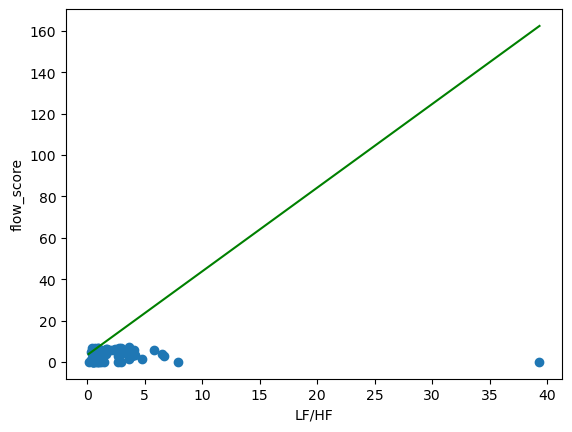

In [25]:
x = flow_dataset["kubios_lf/hf"]
xlabel = "LF/HF"

y = flow_dataset[["questionnaire_average"]]
ylabel = "flow_score"

result2 = smf.ols('questionnaire_average ~ concentration_FCz', data=flow_dataset).fit()

#graph
plt.scatter(x, y)
x = x.sort_values()
b0_2, b1_2 = result2.params
plt.plot(x, b0_2 + b1_2*x, 'g')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.savefig(f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/image/{ylabel}_1next.png")
plt.show()

# 2次

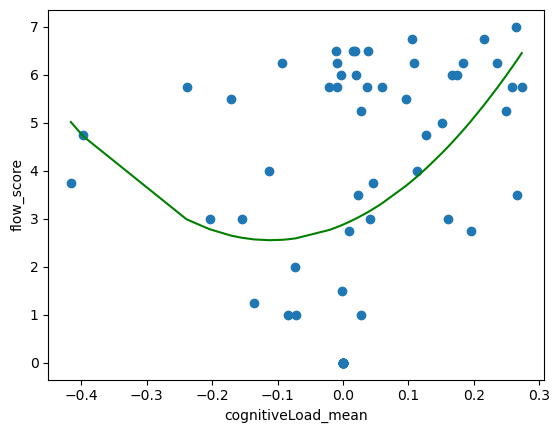

In [43]:
x = flow_dataset["concentration_mean"]
xlabel = "cognitiveLoad_mean"

y = flow_dataset[["questionnaire_average"]]
ylabel = "flow_score"

result2 = smf.ols('questionnaire_average ~ concentration_mean + np.power(concentration_mean, 2)', data=flow_dataset).fit()

#graph
plt.scatter(x, y)
x = x.sort_values()
b0_2, b1_2, b2_2 = result2.params
plt.plot(x, b0_2 + b1_2*x + b2_2*x**2, 'g')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.savefig(f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/image//{xlabel}_{ylabel}_2next.png")
plt.show()

# overloadを抜いたやつで分析してみる

In [27]:
# 使用するデータセットは一つなので，ここでまとめて作っちゃいましょう

for i,target_phase in enumerate(Constants.target_phases):
    
    if target_phase == "overload":
        continue
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0 and i == 0:
            print("flow_dataset初期化")
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
        

for i,target_phase in enumerate(Constants.target_phases):


    export_data = {    
        "target": Constants.target_columns,
        "linear-p": [],
        "linear-rsquared": [],
        "linear-rsquared_adj": [],
        "linear-coef": [],
        "nonlinear-p": [],
        "nonlinear-rsquared": [],
        "nonlinear-rsquared_adj": [],
        "nonlinear-coef": [],
    }

    for target_column in Constants.target_columns:
        
        x = flow_dataset[target_column]
        y = flow_dataset[["questionnaire_average"]]
        
        for k in ["linear", "nonlinear"]:
            if k=="linear":
                # 線形単回帰
                X = sm.add_constant(x)
                model = sm.OLS(y, X)
                results = model.fit()

                export_data["linear-p"].append(results.pvalues[target_column])
                export_data["linear-rsquared"].append(results.rsquared)
                export_data["linear-rsquared_adj"].append(results.rsquared_adj)
                export_data["linear-coef"].append(results.params[target_column])
            if k=="nonlinear":
                # ２次単回帰
                x = x[:,np.newaxis]
                polynomial_features= PolynomialFeatures(degree=2)
                xp = polynomial_features.fit_transform(x)
                xp.shape

                model = sm.OLS(y, xp)
                
                results = model.fit()
                
                export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
                export_data["nonlinear-rsquared"].append(results.rsquared)
                export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
                export_data["nonlinear-coef"].append(results.params[pvalue_index])
    
    print(f"\nsaving {target_phase} phase regression results...\n")
    df = pd.DataFrame(export_data)   
    print(df)
    save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/all_regressiton_without_overload.csv"
    df.to_csv(save_path)  

flow_dataset初期化


/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e


saving rest phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm  0.494646         0.007555            -0.008452   
1                  ibi  0.942519         0.000085            -0.016043   
2                   lf  0.009821         0.102729             0.088257   
3                   hf  0.012604         0.096239             0.081662   
4                lf/hf  0.306199         0.016880             0.001023   
5            kubios_lf  0.008217         0.107361             0.092963   
6            kubios_hf  0.008347         0.106954             0.092550   
7         kubios_lf/hf  0.299051         0.017382             0.001533   
8                 sdsd  0.073010         0.050915             0.035607   
9                rmssd  0.108510         0.041015             0.025548   
10               pnn20  0.254786         0.020865             0.005073   
11               pnn50  0.136838         0.035345             0.019786


saving ultra phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm  0.494646         0.007555            -0.008452   
1                  ibi  0.942519         0.000085            -0.016043   
2                   lf  0.009821         0.102729             0.088257   
3                   hf  0.012604         0.096239             0.081662   
4                lf/hf  0.306199         0.016880             0.001023   
5            kubios_lf  0.008217         0.107361             0.092963   
6            kubios_hf  0.008347         0.106954             0.092550   
7         kubios_lf/hf  0.299051         0.017382             0.001533   
8                 sdsd  0.073010         0.050915             0.035607   
9                rmssd  0.108510         0.041015             0.025548   
10               pnn20  0.254786         0.020865             0.005073   
11               pnn50  0.136838         0.035345             0.01978

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_31067/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e

# 線形重回帰分析（マルチこに気をつけよう）

In [28]:
# x = flow_dataset[["bpm", "ibi","mean_3ch"]]
# y = flow_dataset[["questionnaire_average"]]

# #全要素が1の列を説明変数の先頭に追加,切片をつけるために必ず必要
# X = sm.add_constant(x)
 
# #モデルの設定
# model = sm.OLS(y, X)
 
# #回帰分析の実行
# results = model.fit()
 
# #結果の詳細を表示
# print(results.summary())

## いい結果のように思えるが、多重共線性により偽の有意性が出てしまっている

### 参考
- https://takacity.blog.fc2.com/blog-entry-305.html
- https://self-development.info/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E8%84%B1%E5%87%BA%E3%80%91statsmodels%E3%81%AB%E3%82%88%E3%82%8B%E9%87%8D%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90%E7%B5%90%E6%9E%9C%E3%81%AE%E8%A6%8B%E6%96%B9/
- https://teratail.com/questions/256310

In [29]:
# 決定係数
# 0.9以上	非常によい
# 0.7以上0.9未満	よい
# 0.5以上0.7未満	あまりよくない
# 0.5未満	悪い

# Dep. Variable:     questionnaire_average   R-squared:                       0.915（決定係数。説明変数が目的変数をどれくらい説明できるか）
# Model:                               OLS   Adj. R-squared:                  0.893（自由度調整済み決定係数）
# Method:                    Least Squares   F-statistic:                     42.82（F値）
# Date:                   Fri, 13 Jan 2023   Prob (F-statistic):            0.00282（F値の現れる確率）
# Time:                           12:17:03   Log-Likelihood:                 2.8630
# No. Observations:           データの行数   AIC:                            -1.726
# Df Residuals:               残差の自由度   BIC:                            -2.142
# Df Model:                   要因の自由度                                        
# Covariance Type:  nonrobust（変数間の相関関係）


#       coef（回帰係数。傾き）    std err（標準誤差）  t      P>|t|      [0.025  0.975]
# ------------------------------------------------------------------------------
# const          7.3625      0.174     42.246      0.000       6.879       7.846
# lf         -6.729e-06   1.03e-06     -6.544      0.003   -9.58e-06   -3.87e-06
# ==============================================================================
# Omnibus:                          nan   Durbin-Watson:                   1.765
# Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.156
# Skew:                          -0.179   Prob(JB):                        0.925
# Kurtosis:                       2.296   Cond. No.                     3.93e+05
# ==============================================================================

In [30]:
dir(results)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'info_criteria',


In [31]:
print(results.__doc__)


    Results class for for an OLS model.

    Parameters
    ----------
    model : RegressionModel
        The regression model instance.
    params : ndarray
        The estimated parameters.
    normalized_cov_params : ndarray
        The normalized covariance parameters.
    scale : float
        The estimated scale of the residuals.
    cov_type : str
        The covariance estimator used in the results.
    cov_kwds : dict
        Additional keywords used in the covariance specification.
    use_t : bool
        Flag indicating to use the Student's t in inference.
    **kwargs
        Additional keyword arguments used to initialize the results.

    See Also
    --------
    RegressionResults
        Results store for WLS and GLW models.

    Notes
    -----
    Most of the methods and attributes are inherited from RegressionResults.
    The special methods that are only available for OLS are:

    - get_influence
    - outlier_test
    - el_test
    - conf_int_el
    


In [32]:
dir(results.params)

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__redu

- [pandas dictionary出力](https://note.nkmk.me/python-pandas-to-csv/)
- [pandas dictionary出力](https://atmarkit.itmedia.co.jp/ait/articles/2109/14/news024.html)

# sandbox

In [33]:
flow_dataset

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,lf_diff,hf_diff,lfhf_diff,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
rest,74.087015,809.858521,41.250305,20.146486,36.787621,0.619355,0.183871,30.0,26.012686,52.268898,4271.480335,0.497670,0.300000,396.011131,338.306267,533.157937,0.634533,1267.475336,31.244090,26.691349,42.064561,38.820443,61.179557,0.000000,0.000000,0.000000,257.0,510.0,0.500,0.470375,0.718243,0.530592,0.783054,0.352428,0.286579,0.390179,0.504493,0.677296,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.00
rest,84.110828,713.344538,35.699439,17.214344,27.709366,0.432584,0.067416,22.0,19.593268,46.540635,2864.765352,0.420993,0.133333,267.138630,631.637193,212.740305,2.969053,1111.516129,24.033716,56.826633,19.139651,74.805072,25.194928,0.000000,0.000000,0.000000,591.0,219.0,2.700,0.422667,0.593262,0.690615,0.725889,0.310892,0.438972,0.430201,0.516071,0.669922,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,75.220071,797.659443,40.900640,13.923616,22.012701,0.304348,0.021739,20.0,15.564184,55.685590,2722.820846,0.279501,0.133333,316.777455,1231.720452,138.655648,8.883305,1687.153555,18.775852,73.005830,8.218318,89.881927,10.118073,0.000000,0.000000,0.000000,1044.0,133.0,7.863,0.367564,0.525578,0.305216,0.487435,0.320239,0.311307,0.395218,0.387508,0.439410,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,69.352315,865.147766,97.031908,17.478813,31.990300,0.593103,0.103448,68.0,22.620469,135.393695,9621.658211,0.167072,0.100000,6128.267686,3421.219463,63.168555,54.160166,9612.655704,63.752077,35.590783,0.657139,98.187098,1.812902,0.000000,0.000000,0.000000,3530.0,90.0,39.337,0.413260,0.519220,0.549392,0.696971,0.218319,0.247750,0.270101,0.416431,0.588528,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,75.038981,799.584416,82.250228,34.261413,49.297373,0.567657,0.231023,47.0,34.849896,109.839201,12025.654369,0.317281,0.133333,4390.708426,2147.469055,1332.822690,1.611219,7871.000171,55.783361,27.283306,16.933333,61.703708,38.296292,0.000000,0.000000,0.000000,2373.0,2504.0,0.948,0.254564,0.437716,0.493796,0.484021,0.533929,0.538550,0.234585,0.425309,0.471844,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,77.013055,779.088685,39.542198,14.586589,26.734780,0.484663,0.033742,28.0,18.903769,52.596740,3123.612142,0.359410,0.233333,760.024674,324.690340,340.109566,0.954664,1424.824581,53.341631,22.788092,23.870276,48.840311,51.159689,0.000000,0.000000,0.000000,327.0,379.0,0.861,0.343346,0.171872,0.419099,0.553422,0.191685,0.212534,0.198741,0.298671,0.381464,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,74.176804,808.878205,30.110234,11.137601,19.383731,0.277419,0.019355,15.0,13.705729,40.351278,1737.437985,0.339660,0.133333,229.517331,282.845325,150.704932,1.876815,663.067587,34.614470,42.657088,22.728442,65.239340,34.760660,0.000000,0.000000,0.000000,212.0,146.0,1.448,0.459175,0.295876,0.565212,0.703698,0.205356,0.246868,0.291289,0.395353,0.521595,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,73.292489,818.637771,46.744964,17.953896,30.466966,0.500000,0.090062,28.0,21.542646,62.521983,4231.376378,0.344561,0.133333,801.266688,819.546700,315.134442,2.600626,1935.947831,41.388857,42.333098,16.278044,72.227049,27.772951,0.000000,0.000000,0.000000,883.0,301.0,2.937,0.395495,0.652412,0.738686,0.764774,0.222967,0.249696,0.302828,0.475265,0.718624,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,52.498950,1142.880000,87.693551,53.126065,101.641088,0.870536,0.727679,66.0,71.870929,100.674178,22731.140401,0.713896,0.233333,1450.919208,401.670418,4529.935860,0.088670,6382.525486,22.732682,6.293283,70.974035,8.144819,91.855181,0.000000,0.000000,0.000

In [34]:
import scipy.stats as stats

